# Families distribution report

In this notebook the distribution of the malware family over time is analyzed.
It's shown that:
- Most of the data samples were firstly submitted near 2022, except two small peaks in 2018 and 2013
- Using a timespan of 1 year, 2018 is the first year in terms of number of discovered families. 
    As the timespan increases, the evidence of a higher change in new discovered families is clear in the second half of the collected data.

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [32]:
# Get the merged malware data
df = pd.read_csv("vt_reports/merge.csv")
df.head()

,sha256,first_submission_date,family
0,98f8e26e12b978102fa39c197f300ebe5fe535617737d5...,1630575593,tnega
1,7b2999ffadbc3b5b5c5e94145ca4e2f8de66ac1e3ddd52...,1629375559,quasar
2,e7569d494fe00be04ef6c9fcc5e54720c0df623b08e79d...,1362057319,pasta
3,1ed60c04f572b6acb9f64c31db55ef5c6b5465bd4da1eb...,1630624233,cjishu
4,4c4aaff20a57213d9a786e56ad22f1eaa94694a2f1042b...,1592186154,kingsoft


In [33]:
# Convert the date to datetime
df1 = df.copy()
df1['first_submission_date'] = df['first_submission_date'].apply(
    lambda t: pd.to_datetime(t, unit='s')
)

<Figure size 1500x1000 with 0 Axes>

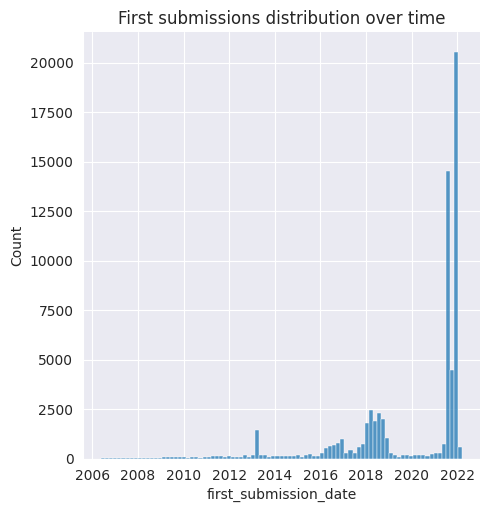

In [34]:
# Plot the distribution of first submissions over time
plt.figure(figsize=(15, 10))
dist_plot = sns.displot(df1, x='first_submission_date')
plt.title("First submissions distribution over time")
plt.show()

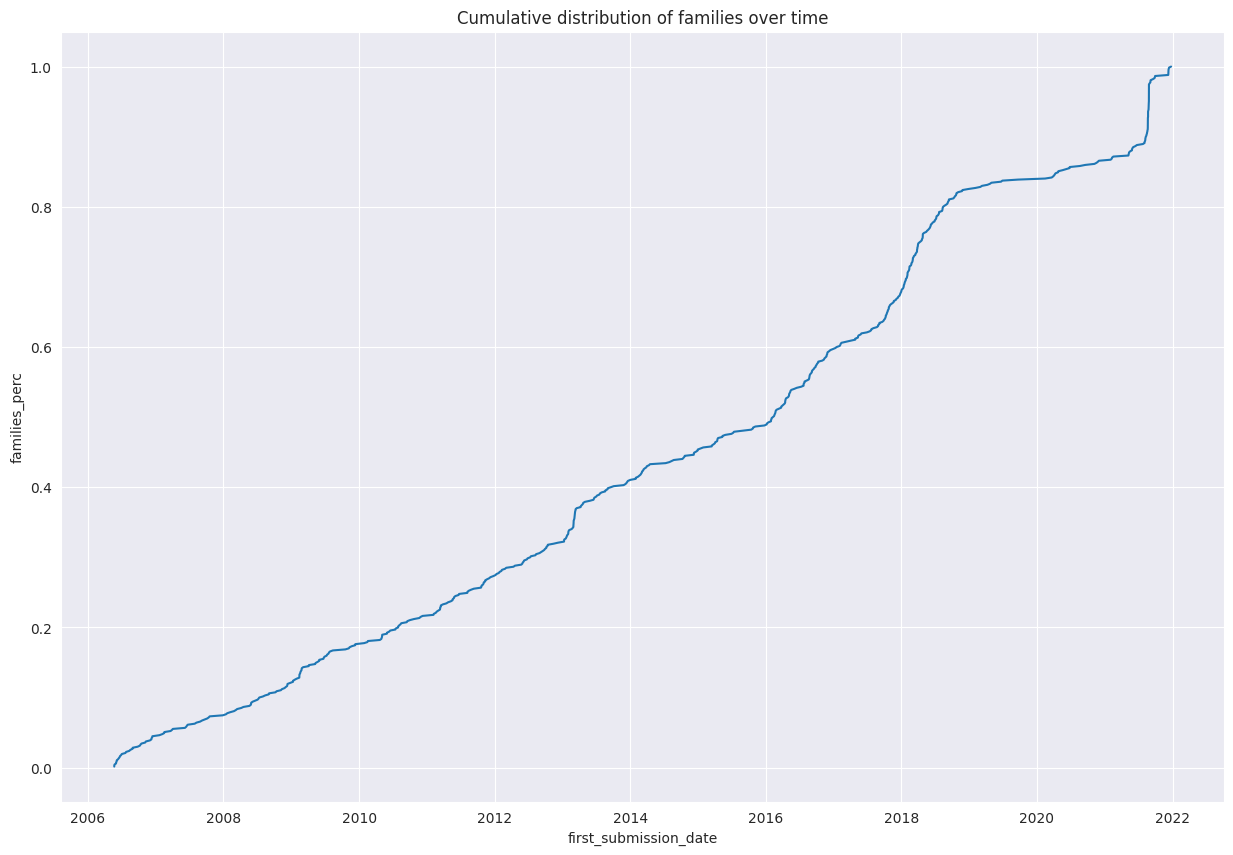

In [35]:
cumulative_df = pd.DataFrame(df1[["family", "first_submission_date"]], index=None)

# Group by the rows by the malware family, minimizing the first submission date
cumulative_df = cumulative_df.groupby(by=["family"]).min()

n = len(cumulative_df)
# For each timestamp, get the number of families previously discovered
cumulative_df['families_perc'] = cumulative_df['first_submission_date'].apply(
    lambda t: len(cumulative_df[cumulative_df['first_submission_date'] <= t]) / n
)

# Sort the submission date in ascending order
cumulative_df = cumulative_df.sort_values(by="first_submission_date")

# Plot the distribution of first submissions over time
plt.figure(figsize=(15, 10))
plt.title("Cumulative distribution of families over time")
sns.lineplot(cumulative_df, x="first_submission_date", y="families_perc")
plt.show()

In [26]:
timestamp_to_datetime = lambda t: pd.to_datetime(t, unit='s')
datetime_to_timestamp = lambda t: t.timestamp()


# Fit linear regression
def lin_reg_fit(df_split):
    df_split["first_submission_date"] = df_split["first_submission_date"].apply(
        lambda t: datetime_to_timestamp(t)
    )
    X, y = (df_split[["first_submission_date"]].to_numpy(),
            df_split["families_perc"].to_numpy())
    return LinearRegression().fit(X, y), X, y


# Plot regressions 
def plot_regressions(reg_data, max_slope_idx):
    fig, ax = plt.subplots()
    plt.title("Window-based linear regression")

    for i in range(len(reg_data)):
        reg, X, _ = reg_data[i]
        X1 = timestamp_to_datetime(X.ravel())
        df1 = pd.DataFrame({"first_submission_date": X1, "families_perc": reg.predict(X)})
        #sns.scatterplot(cumulative_df, x="first_submission_date", y="families_perc")
        sns.lineplot(df1, x="first_submission_date", y="families_perc", 
                     linewidth=3 if i == max_slope_idx else 1, ax=ax)
    plt.show()

In [27]:
from sklearn.linear_model import LinearRegression

#min_datetime = timestamp_to_datetime(df["first_submission_date"].min())
#max_datetime = timestamp_to_datetime(df["first_submission_date"].max())

# Min and maximum dates
date_min = df1["first_submission_date"].min()
date_max = df1["first_submission_date"].max()

total_duration = date_max - date_min

def window_linear_regression(n_windows=2):
    window_size = total_duration / n_windows

    windows = [i * window_size for i in range(n_windows + 1)]
    splits = [cumulative_df[
                  (cumulative_df["first_submission_date"] - date_min >= windows[i - 1]) &
                  (cumulative_df["first_submission_date"] - date_min < windows[i])]
              for i in range(1, len(windows))]

    regressions_data = []
    slopes = []
    for split in splits:
        regression_data = lin_reg_fit(split)
        regressions_data.append(regression_data)
        slopes.append(regression_data[0].coef_[0])

    index_max = np.argmax(slopes)
    plot_regressions(regressions_data, index_max)

In [28]:
%matplotlib inline
from ipywidgets import *
import matplotlib as mpl
#mpl.use('Qt5Agg')  # or can use 'TkAgg', whatever you have/prefer

n_windows = date_max.year - date_min.year
interact(window_linear_regression, w=(2, n_windows, 1))

interactive(children=(IntSlider(value=2, description='n_windows', max=6, min=-2), Output()), _dom_classes=('wi…

<function __main__.window_linear_regression(n_windows=2)>

In [36]:
fsd = "first_submission_date"

# Min and maximum dates
date_min = df1[fsd].min()
date_max = df1[fsd].max()

df2 = df1.copy()
df2[fsd] = df2[fsd].apply(lambda d: d.strftime('%Y-%m-%d'))

# Get all the days between min and max
days_range = [d.strftime('%Y-%m-%d') for d in
              pd.date_range(start=date_min, end=date_max, freq='D').tolist()]

# Compute the unique families
families = df2["family"].unique()

# Group by the dataset by family and first_submission_date (converted to format yyyy-mm-dd),
# using size() to count the samples.
# For each line of this new DataFrame, in the count column there is the number of submitted
# samples in a specific day and for a specific family
df_group_by = pd.DataFrame(df2.groupby(["family", fsd]).size().reset_index(name='count'))

family_variances = []
for family in families:
    days_count = np.zeros((date_max - date_min).days + 1)
    # Get the dataset portion where family is equal to the iteration one.
    family_data = df_group_by[df_group_by["family"] == family]
    # From each date compute the offset relative to days_count
    off = [(pd.Timestamp(day) - date_min).days for day in family_data[fsd]]
    # Set each off cell with the respective count
    for index, value in zip(off, family_data["count"]):
        days_count[index] = value
    family_variances.append(np.var(days_count))

# Create a new DataFrame with families and variances
df_variances = pd.DataFrame({"family": families, "variance": family_variances})
df_variances = df_variances.sort_values(by="variance")
# Compute the cumulative distribution
df_variances['families_perc'] = df_variances["variance"].apply(
    lambda t: len(df_variances[df_variances["variance"] <= t]) / len(families)
)
df_variances.head()

,family,variance,families_perc
377,cobra,0.017703,0.001493
282,gendal,0.019088,0.004478
104,kiser,0.019088,0.004478
2,pasta,0.019434,0.007463
90,bestafera,0.019434,0.007463


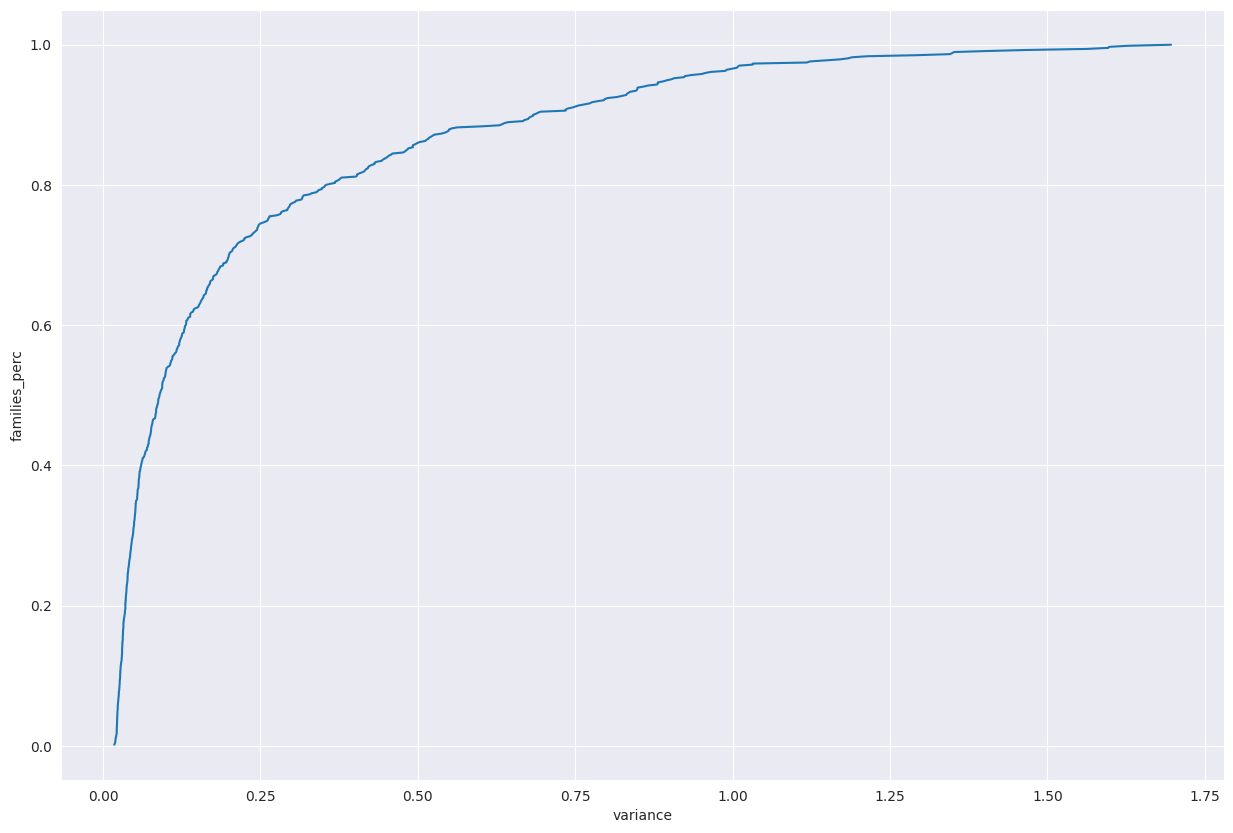

In [37]:
# Plot the distribution of first submissions over time
plt.figure(figsize=(15, 10))
sns.lineplot(df_variances, x="variance", y="families_perc")
plt.show()

In [46]:
df3 = df_variances[df_variances["variance"] < 0.1]



(358, 3)

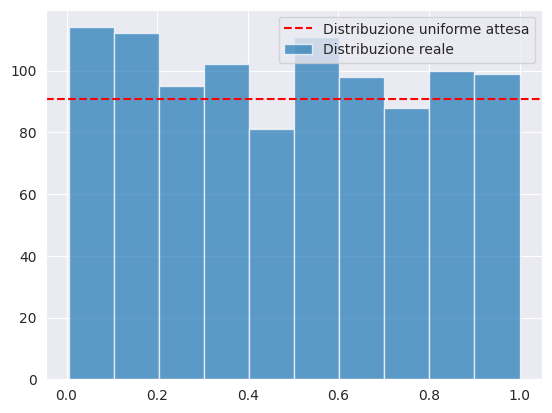

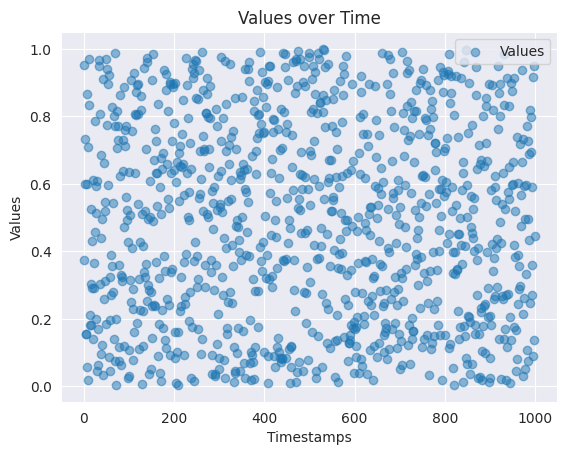

Test del chi-quadro: 20.0909090909091


In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Simula un dataset di timestamp e valori associati
np.random.seed(42)
timestamps = np.arange(0, 1000)
values = np.random.uniform(size=1000)

# Calcola la distribuzione temporale
hist, bins = np.histogram(values, bins=10)

# Calcola la distribuzione uniforme attesa
expected_uniform_distribution = len(timestamps) / len(bins)

# Calcola la discrepanza utilizzando il test del chi-quadro
chi_squared_stat = np.sum((hist - expected_uniform_distribution) ** 2 / expected_uniform_distribution)

# Visualizza l'istogramma
plt.bar(bins[:-1], hist, width=np.diff(bins), align='edge', alpha=0.7, label='Distribuzione reale')
plt.axhline(expected_uniform_distribution, color='red', linestyle='dashed', label='Distribuzione uniforme attesa')
plt.legend()
plt.show()

# Additional visualization for the values
plt.scatter(timestamps, values, alpha=0.5, label='Values')
plt.xlabel('Timestamps')
plt.ylabel('Values')
plt.title('Values over Time')
plt.legend()
plt.show()

print(f"Test del chi-quadro: {chi_squared_stat}")